In [2]:
import torch
from torch import nn
import torchmetrics
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

In [73]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Compose
from numpy import asarray
from patchify import patchify

class ImageDataset(Dataset):
    def __init__(self, image_dir, image_dir_2, transform=None):
        self.image_dir = image_dir
        self.image_dir_2 = image_dir_2
        self.image_files = [i for i in os.listdir(image_dir) if i.endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
        self.images_files_2 = [i for i in os.listdir(image_dir_2) if i.endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
        self.transform = transform
 
    def len(self):
        return len(self.image_files)

    def getItem(self, dirc, files, idx):
        img_path = os.path.join(dirc, files[idx])
        image = Image.open(img_path).convert("L")
        if self.transform:
            image = self.transform(image)
        return image  
    
    def getDataset(self, limit, k):
        total_dataset = []
        for i in range(1, limit):
            if i % 1000 == 0:
                print(f"Have reached {i}/{len(self.image_files)}")
            total_dataset.append(self.getImage(idx=i, k=k, image_dir_1=self.image_dir, image_dir_2=self.image_dir_2, image_files_1=self.image_files, image_files_2=self.images_files_2))
        return total_dataset
    
    def getDatasetTEST(self, start, end, k):
        total_dataset = []
        for i in range(start, end):
            # if i % 1000 == 0:
            #     print(f"Have reached {i}/{len(self.image_files)}")
            total_dataset.append(self.getImage(idx=i, k=k, image_dir_1=self.image_dir, image_dir_2=self.image_dir_2, image_files_1=self.image_files, image_files_2=self.images_files_2))
        print(f"len of total dataset {len(total_dataset)}")
        return total_dataset
    
    def getImage(self, idx, k, image_dir_1, image_dir_2, image_files_1, image_files_2):
        first_list = self.getResultList(image_dir=image_dir_1, image_files=image_files_1, idx=idx, k=k)
        second_list = self.getResultList(image_dir=image_dir_2, image_files=image_files_2, idx=idx, k=k)
        return [first_list, second_list]
    
    def getResultList(self, idx, k, image_dir, image_files):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image_1 = Image.open(img_path).convert("L")
        image_1 = asarray(image_1)
        patches_1 = patchify(image_1, (k, k), k)
        patches_1 = patches_1.reshape((256**2//k**2), k, k)
        tensor_imgs_1 = []
        for i in (range(len(patches_1))):
            random = self.transform(patches_1[i])
            tensor_imgs_1.append(random)
        return tensor_imgs_1
        

In [74]:
from dotenv import load_dotenv
import os

load_dotenv()
clean_dir = os.environ["DATA_DIR"]
noise_dir = os.environ['DATA_DIR_2']

In [ ]:
from patchify import patchify
from numpy import asarray

transformations = Compose([
    ToTensor(), 
])

sample_img_path = r"C:\Users\rahul\Documents\PyFiles\datasets\virtual_sar_training_set\clean_1c\00001.jpg"
sample_img = Image.open(sample_img_path).convert("L")
pre_tensor_img = transformations(sample_img)
sample_img = asarray(sample_img)
print(f'sample_img shape after numpy transformation: {sample_img.shape}')

patches = patchify(sample_img, (32, 32), 32)

print(f'len of patches {patches.reshape(64, 32, 32).shape}')

# rand_img = patches[0][0]
# tensor_img = transformations(rand_img)
# tensor_img.shape

# tesnor_imgs = []

# for i in (range(len(patches))):
#     random = transformations(patches[i][i])
#     tesnor_imgs.append(random)

# tesnor_imgs[0].shape




In [ ]:
transformations = Compose([
    ToTensor(), 
])

train_dataset_32 = ImageDataset(image_dir=clean_dir, image_dir_2=noise_dir, transform=transformations).getDataset(100, k=32)
train_dataset_64 = ImageDataset(image_dir=clean_dir, image_dir_2=noise_dir, transform=transformations).getDataset(100, k=64)
train_dataset_128 = ImageDataset(image_dir=clean_dir, image_dir_2=noise_dir, transform=transformations).getDataset(100, k=128)
test_dataset_32 = ImageDataset(image_dir=clean_dir, image_dir_2=noise_dir, transform=transformations).getDatasetTEST(start=100, end=200, k=32)
test_dataset_64 = ImageDataset(image_dir=clean_dir, image_dir_2=noise_dir, transform=transformations).getDatasetTEST(start=100, end=200, k=64)
test_dataset_128 = ImageDataset(image_dir=clean_dir, image_dir_2=noise_dir, transform=transformations).getDatasetTEST(start=100, end=200, k=128)


In [77]:
from torch.utils.data import DataLoader

BATCH_SIZE = 1

train_dataloader_32 = DataLoader(train_dataset_32, batch_size=BATCH_SIZE, shuffle=True)
train_dataloader_64 = DataLoader(train_dataset_64, batch_size=BATCH_SIZE, shuffle=True)
train_dataloader_128 = DataLoader(train_dataset_128, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader_64 = DataLoader(test_dataset_64, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader_32 = DataLoader(test_dataset_32, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader_128 = DataLoader(test_dataset_128, batch_size=BATCH_SIZE, shuffle=True)

train_list = [train_dataloader_32, train_dataloader_64, train_dataloader_128]
test_list = [test_dataloader_32, test_dataloader_64, test_dataloader_128]

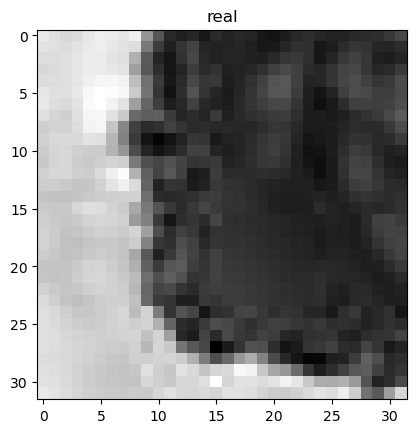

In [129]:
import matplotlib.pyplot as plt
train_data_batches, test_data_batches = next(iter(train_dataloader_32))

sample_img = train_data_batches[0]
plt.imshow(sample_img.squeeze(dim=0).squeeze(dim=0), cmap='gray')
plt.title('real')
plt.show()



In [78]:
class SARDespeckleModel(nn.Module):
    def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
        super().__init__()
        self.initial_stack = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.middle_stack = nn.Sequential(
            *[
                nn.Sequential(
                    nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(num_features=hidden_units),
                    nn.ReLU()
                )
                for _ in range(2)
            ]
        )
        self.final_stack = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=output_shape, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
    
        self.tanh_layer = nn.Tanh()

    def forward(self, initial:torch.Tensor):
        x = self.initial_stack(initial)
        x = self.middle_stack(x)
        x = self.final_stack(x)
        img = self.tanh_layer(x)
        return img

In [79]:
num_k = [32, 64, 128]
kmodels = [[SARDespeckleModel(1, 64, 1) for i in range(int(256**2/k**2))] for k in num_k]

In [80]:
def total_variation_loss(img, weight):
    bs_img, c_img, h_img, w_img = img.size()
    tv_h = torch.pow(img[:,:,1:,:]-img[:,:,:-1,:], 2).sum()
    tv_w = torch.pow(img[:,:,:,1:]-img[:,:,:,:-1], 2).sum()
    return weight*torch.sqrt(tv_h+tv_w)


def loss_fn(predicted, target):
    mse_loss = nn.MSELoss()
    L_E = mse_loss(predicted, target) 
    L_TV = total_variation_loss(predicted, .002)
    loss = L_E +  L_TV
    return loss

In [81]:
from tqdm.auto import tqdm

EPOCHS = 3

def noLossFr(epochs):
    for i in zip(kmodels, train_list):
        models, dataloader = i
        for patch_num, model in enumerate(models):
            for epoch in tqdm(range(epochs)):
                optimizer = torch.optim.Adam(params=model.parameters(), lr=0.002)
                total_loss =0
                model.to(device)
                model.train()
                for batch, image in enumerate(dataloader):
                    clean_img= image[0][patch_num]
                    noise_img = image[1][patch_num]
                    clean_img, noise_img = clean_img.to(device), noise_img.to(device)
                    img_pred = model(noise_img)
                    loss = loss_fn(img_pred, clean_img)
                    total_loss += loss
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                
                    if batch % 400 ==0:
                        print(f"We have passed {batch * len(clean_img)}/{len(dataloader.dataset)} samples")
                        print(f'Current Accumalting Total Loss: {total_loss:.6f} | Current Loss: {loss} \n---------')
    
        total_loss /= len(dataloader)
        print(f"So far our train loss has been: {total_loss:.3f}")


In [ ]:
noLossFr(2)

In [109]:
image_preds = []

with torch.inference_mode():
    for i in zip(kmodels, test_list):
        models, dataloader = i
        inner_arr = []
        for patch_num, model in enumerate(models):
            total_loss =0
            model.to(device)
            model.eval()
            patch_preds = []
            for batch, image in enumerate(dataloader):
                clean_img= image[0][patch_num]
                noise_img = image[1][patch_num]
                clean_img, noise_img = clean_img.to(device), noise_img.to(device)
                img_pred = model(noise_img)
                imsample = img_pred.cpu()
                patch_preds.append(imsample)
                loss = loss_fn(img_pred, clean_img)
                total_loss += loss
            total_loss /= len(dataloader)
            # print(f"total avg loss: {total_loss}")
            inner_arr.append(patch_preds)
        image_preds.append(inner_arr)

len(image_preds)

3

In [121]:
import numpy as np
from patchify import unpatchify

def patching_together():
    images = []
    for k in range(len(num_k)):
        # image_preds[k] = image_preds[k].cpu()
        np_preds = np.array(image_preds[k])
        np_preds = np_preds.swapaxes(0, 1)
        np_preds = np_preds.reshape(len(image_preds[k][0]), 256//num_k[k], 256//num_k[k], num_k[k], num_k[k])
        np_preds = [unpatchify(patches, (256, 256)) for patches in np_preds]
        images.append(np_preds)
    images = np.array(images)
    images = np.mean(images, axis=1)
    return images

images = patching_together()

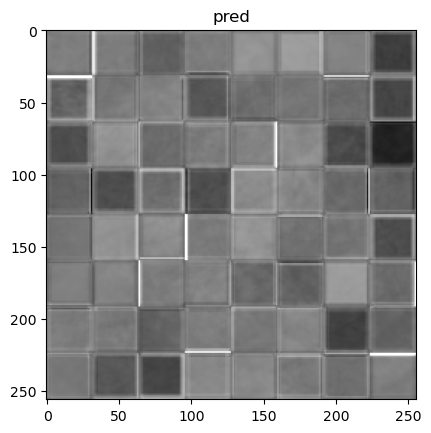

In [122]:
import matplotlib.pyplot as plt

sample_image = images[0]

plt.imshow(sample_image, cmap='gray')
plt.title('pred')
plt.show()
